In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn')


In [3]:
# path = open('document.txt', 'r').read().strip()
# os.listdir(f'{path}')

# df_data = pd.DataFrame([])
# for year in range(2015,2020):
#     df_temp = pd.read_feather(f"{path}/{year}_street.feather")
#     filter = df_temp['Falls within'].str.contains('South Wales')
#     df_temp = df_temp[filter]
#     df_temp = df_temp[df_temp['Crime type']=='Violence and sexual offences']
#     df_temp = df_temp['Month'].value_counts().sort_index()
#     df_data = pd.concat([df_data, df_temp])
#     del df_temp
# df_data.to_pickle('2015-2019.pkl')


In [4]:
df_data = pd.read_pickle('2015-2019.pkl')


In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_data.index = pd.to_datetime(df_data.index)

decomposition = seasonal_decompose(df_data, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
df_data = df_data.reset_index()


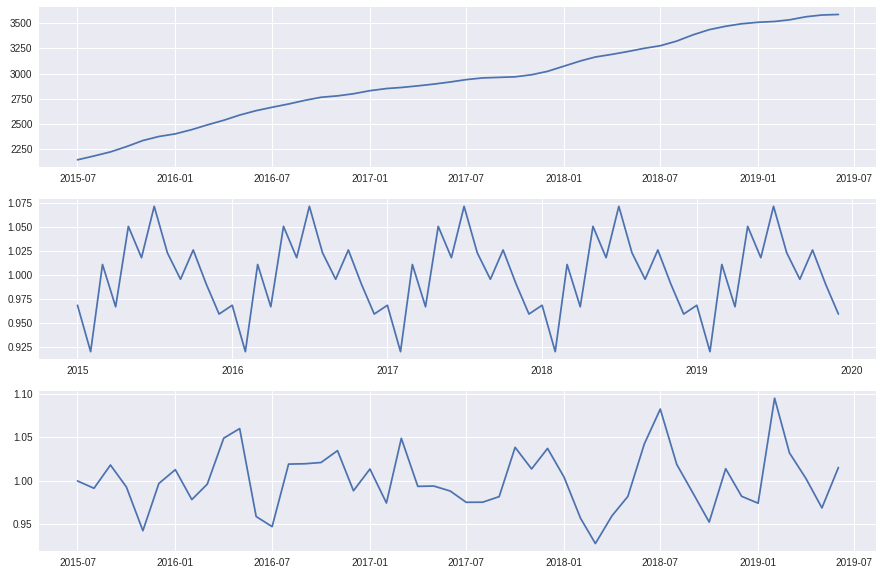

In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 10))
ax[0].plot(trend)
ax[1].plot(seasonal)
ax[2].plot(residual)


In [7]:


def fourierExtrapolation(x, n_predict, harmonies):
    n = x.size

    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)

    for i in indexes[:1 + harmonies * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t


# def plot_graph(row, extrapolation, uncertainty, harmonics):
#     ax[row].plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
#     ax[row].plot(data=x_train, x=x_train.index, y=0, label = 'Training', linewidth = 3)
#     ax[row].plot(df_test[0], label='Testing')
#     # ax[row].fill_between(list(range(0, 24)), uncertainty[1], uncertainty[0], alpha=0.3, facecolor=clrs[3])
#     ax[row].set_title(f'fourier transform with {harmonics} harmonics', size=20)
#     ax[row].set_ylabel(f'amount of crimes', size=20)
#     ax[row].set_xlabel(f'months since jan 2015', size=20)
#     ax[row].legend(prop={'size': 16});

# def generate_fourier(harmonics, n_predict):
#     extrapolation = fourierExtrapolation(x, n_predict, harmonics)
#     uncertainty = [extrapolation + 0.5*np.std(extrapolation), extrapolation-0.5*np.std(extrapolation)]
#     return extrapolation, uncertainty

# def group(harmonics, n_predict, row):
#     extrapolation, uncertainty = generate_fourier(harmonics, n_predict)
#     plot_graph(row, extrapolation, uncertainty, harmonics)
#     plt.xticks(size=15)
#     plt.yticks(size=15)


In [8]:
clrs = sns.color_palette("colorblind", 5)

def cross_validate(begin, end, n_predict, harmonics, ax):
        train = df_data.loc[begin:end]
        df_data['predictions'] = np.nan
        df_data['predictions'].iloc[begin:end+n_predict +
                                1] = fourierExtrapolation(train[0], n_predict, harmonics)

        Y = df_data.iloc[end:end+n_predict+1][0]
        y_pred = df_data.iloc[end:end+n_predict+1]['predictions']

        mse = mean_squared_error(Y, y_pred)
        r2 = r2_score(Y, y_pred)
        mae = mean_absolute_error(Y, y_pred)
        rmse = mean_squared_error(Y, y_pred, squared=False)
        # print(f'mse: {mse}\nr^2: {r2}\nrmse: {rmse}\nmae:{mae}')
        # print(end+n_predict+1)
        print(r2)

        test = df_data[0].copy()




        # ax[0].plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
        ax.plot(test, label='Actual', c=clrs[1])
        ax.plot(df_data.index, df_data['predictions'],
                label='predictions', linewidth=3, c=clrs[4])
        ax.plot(train.index, train[0], label='Training', linewidth=3, c=clrs[2])


        # ax.fill_between(list(range(0, 24)), uncertainty[1], uncertainty, alpha=0.3, facecolor=clrs[3])
        ax.set_title(f'fourier transform with {harmonics} waves', size=20)

        ax.legend(prop={'size': 16})

        return mse, r2, mae, rmse


0.5860231740492641
0.3615787523398538
-1.4802455622651642


(145.18462813003825, 176.7801696449582, 34055.58796405797)

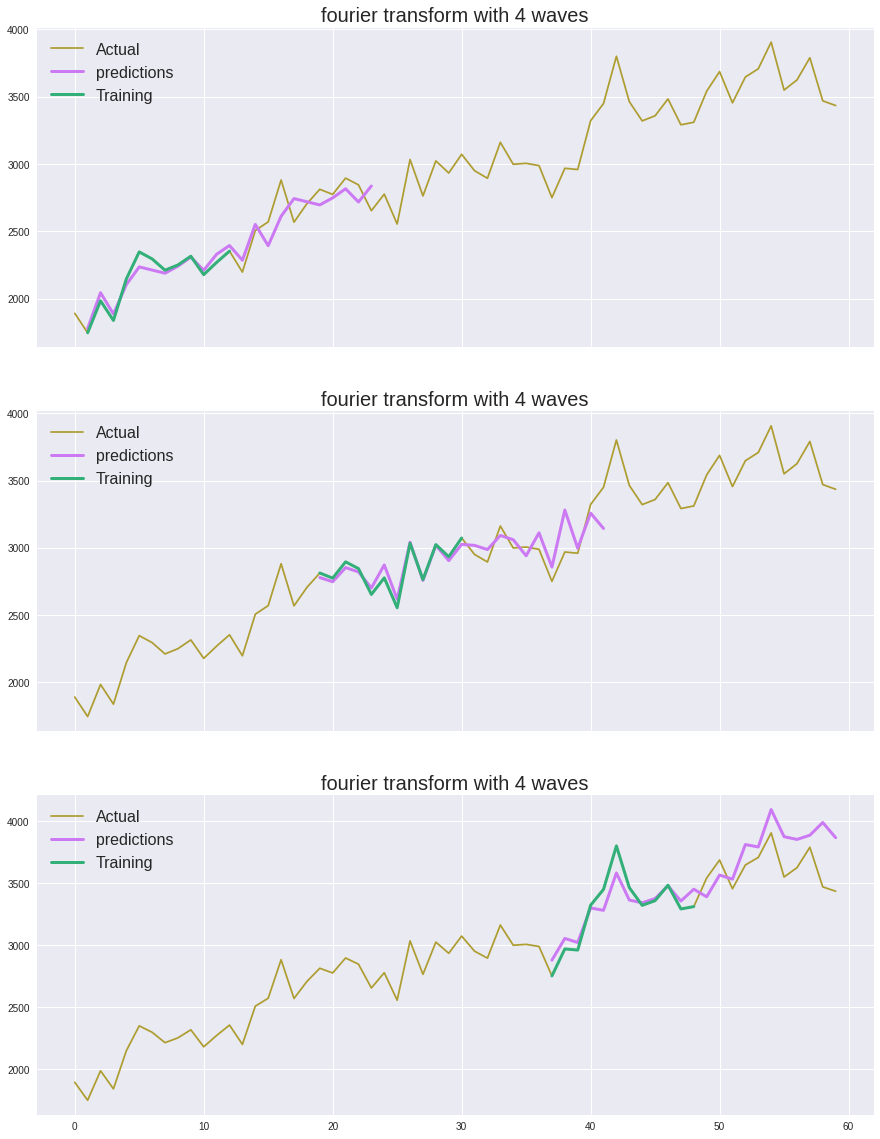

In [9]:
mae = []
rmse = []
mse=[]
counter = 0

clrs = sns.color_palette("husl", 5)
fig, ax = plt.subplots(nrows=3, figsize=(15,20), sharex=True)


for i in range(1, 48, 18):
    results = cross_validate(i, i+11, 11, 4, ax[counter])
    mae.append(results[2])
    rmse.append(results[3])
    mse.append(results[0])
    counter +=1 
    
    
    
np.mean(mae), np.mean(rmse), np.mean(mse)

In [10]:
np.mean([0.6334297950439418,
0.3447691117030164,
-1.5133232431736041])

-0.17837477880888197

In [11]:
# ten = cross_validate(0, i+end, 7, 12, ax[1])


-0.03046651057451566
0.022538503205749683

(30912.17828161327, -0.03046651057451566, 148.02171676496394, 175.81859481184938)

(29322.121332667477, 0.022538503205749683, 133.58103978088715, 171.237032597121)


Text(0.5, 0, 'months since jan 2015')

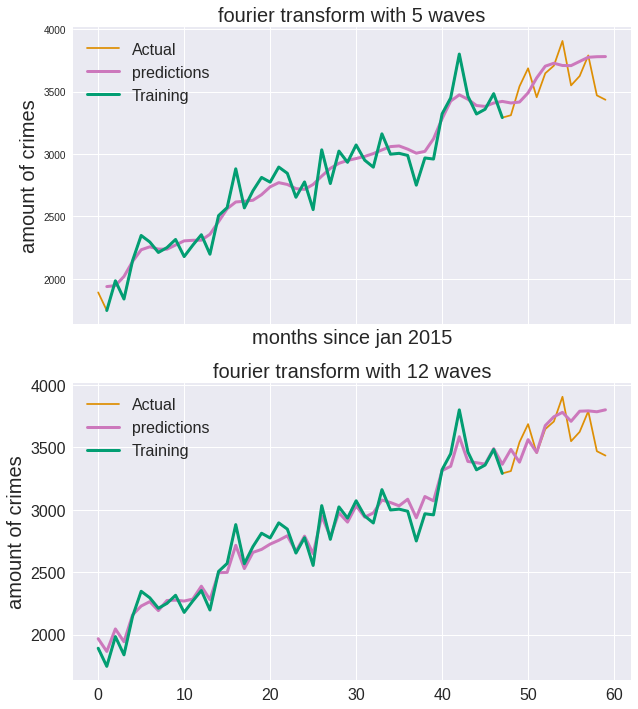

In [21]:
end = 10
clrs = sns.color_palette("colorblind", 5)
fig, ax = plt.subplots(nrows=2, figsize=(10,12), sharex=True)
five = cross_validate(1, i+end, 12, 5, ax[0])
ten = cross_validate(0, i+end, 12, 12, ax=ax[1])

print(f'\n{five}')
print(f'\n{ten}')
ax[0].set_ylabel(f'amount of crimes', size=20)
ax[0].set_xlabel(f'months since jan 2015', size=20)
ax[1].set_ylabel(f'amount of crimes', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax[0].set_xlabel(f'months since jan 2015', size=20)


In [25]:
# train = df_data.loc[0:36]
# test = df_data[0].copy()


# clrs = sns.color_palette("husl", 5)
# fig, ax = plt.subplots(figsize=(9, 5), sharex=True)

# # ax[0].plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
# ax.plot(test, label='Actual')
# ax.plot(df_data.index, df_data['predictions'],
#            label='predictions', linewidth=3, c='r')
# ax.plot(train.index, train[0], label='Training', linewidth=3)


# # ax.fill_between(list(range(0, 24)), uncertainty[1], uncertainty, alpha=0.3, facecolor=clrs[3])
# ax.set_title(f'fourier transform with {harmonics} harmonics', size=20)
# ax.set_ylabel(f'amount of crimes', size=20)
# ax.set_xlabel(f'months since jan 2015', size=20)
# ax.legend(prop={'size': 16})


In [13]:
# # df_train = df_data.iloc[:36]
# # df_test = df_data.iloc[36:]
# # x = df_train[0].to_numpy()
# df_test = df_data.loc['2016-01-01':]
# x = df_data.loc[:'2015-12-01'][0].to_numpy()
# df_test.reset_index(inplace=True)
# df_test.set_index([pd.Index(list(range(12,36)))], inplace=True)

# clrs = sns.color_palette("husl", 5)
# fig, ax = plt.subplots(nrows=2,figsize=(9,12), sharex=True)
# group(5, 0)
# group(15, 1)


In [14]:
# x_train = df_data.loc[12:24][0].to_numpy()
# df_test = df_data
# # df_test = df_data.loc['2017-01-01':]
# # df_test.reset_index(inplace=True)
# # df_test.set_index([pd.Index(list(range(12,36)))], inplace=True)


# clrs = sns.color_palette("husl", 5)
# fig, ax = plt.subplots(nrows=2,figsize=(9,12), sharex=True)
# group(5, 12, 0)
# group(15, 12, 1)
